<span id=title style="font-size:22pt; color:#f37826">Time-Optimal Trajectory Generation for Planar Drone</span>

# Housekeeping

## Import packages

In [1]:
import numpy as np
import casadi as cas
import matplotlib.pyplot as plt
import jdc

import sys
sys.path.append("./models")
sys.path.append("./auxiliary")
from auxiliary import tools
from planar_drone import PlanarDrone
from visualization import AnimateTrajectory

## Initialize trajectory generator

The trajectory generator is based on a planar drone model

$$\begin{align}
\dot{s} &= f(s, a)
\\[0.5ex]
s &= \begin{bmatrix} x, & z, & \dot{x}, & \dot{z}, & \varphi, & \dot{\varphi} \end{bmatrix}^\top
\\[0.5ex]
a &= \begin{bmatrix} F_1, & F_2 \end{bmatrix}^\top
\\[0.5ex]
f(s, a) &= \begin{bmatrix} \dot{x} \\ \dot{z} \\ \dfrac{1}{m} \cdot \sin(\varphi) \cdot (F_1 + F_2) \\ \dfrac{1}{m} \cdot \cos(\varphi) \cdot (F_1 + F_2) - g \\ \dot{\varphi} \\ \dfrac{1}{I_{yy}} \cdot (F_1 - F_2) \cdot L \end{bmatrix}
\end{align}$$

with a state vector consisting of the horizontal and vertical coordinates $x$ and $z$, their respective time derivatives $\dot{x}, \dot{z}$, as well as the tilt angle $\varphi$ and its time derivative $\dot{\varphi}$.
The thrusts generated by the left and right rotor comprise the action vector.

In [2]:
class TrajectoryGenerator(PlanarDrone):
    def __init__(self, waypoint=np.array([2, 2]), steps_to_waypoint=300, enable_regularization=False, enable_obstacle=False):
        super(TrajectoryGenerator, self).__init__()
        self.n_coordinates = 2
        self.coordinate_indices = [0, 1]
        self.non_coordinate_indices = [2, 3, 4, 5]
        self.n_internal_integration_steps = 1
        self.upper_bound_stepsize = 2e-03
        self.lower_bound_stepsize = 1e-06
        self.stepsize_init = 1.5e-03
        self.waypoint = waypoint if isinstance(waypoint, list) else [waypoint]
        self.steps_to_waypoint = len(waypoint) * [steps_to_waypoint]
        self.enable_regularization = enable_regularization
        self.enable_obstacle = enable_obstacle
        self.solver_options = {'expand':True, 'print_time':False, 'ipopt':{'linear_solver':'ma27', 'print_level':0}}
        
        # Circular obstacle
        self.obstacle_midpoint = np.array([1., 0.75])
        self.obstacle_radius = 0.6
        t = np.linspace(0, 2 * np.pi, 1000)
        self.obstacle = [
            self.obstacle_radius * np.sin(t) + self.obstacle_midpoint[0],
            self.obstacle_radius * np.cos(t) + self.obstacle_midpoint[1],
        ]
        
        # Functions to be defined in the course of the notebook
        self.augment_dynamics()
        self.apply_time_transformation()
        self.discretize_dynamics()
        self.initialize_state_selector()
        self.initialize_action_selector()
        self.initialize_nonlinear_problem()
    
    def augment_dynamics(self):
        NotImplemented
    
    def apply_time_transformation(self):
        NotImplemented
        
    def discretize_dynamics(self):
        NotImplemented
    
    def initialize_state_selector(self):
        NotImplemented
        
    def initialize_action_selector(self):
        NotImplemented
        
    def initialize_nonlinear_problem(self):
        NotImplemented
    
    def print_stats(self):
        print("Terminal time:", self.time_to_waypoint)
        print("Stepsize:", self.stepsize_to_waypoint)
        print("Number of iterations:", self.nlp.stats()['iter_count'])

Left handside of an inequality constraint for avoiding a circular obstacle

In [3]:
%%add_to TrajectoryGenerator
def get_obstacle_avoidance_constraint(self, coordinates):
    tmp = coordinates - self.obstacle_midpoint
    return tmp[0, :]**2 + tmp[1, :]**2 - (self.obstacle_radius + self.parameters.arm_length)**2

Static plots

In [4]:
%%add_to TrajectoryGenerator
def plot_results(self, other_states=[], other_actions=[]):
    states = np.vstack((self.states, self.actions))
    if len(other_states) > 0:
        other_states = np.vstack((other_states, other_actions))
    
    _, ax = plt.subplots(2, 4, tight_layout=True, figsize=(12, 6))
    labels = self.state_labels + self.action_labels
    units = self.state_units + self.action_units
    units[4] = "deg"
    indices = [0, 2, 1, 3, 4, 5, 6, 7]
    
    row = 0; col = 0
    for index in indices:
        state = states[index, :] if index != 4 else np.rad2deg(states[index, :])
        ax[row][col].plot(state)
        if len(other_states) > 0:
            other_state = other_states[index, :] if index != 4 else np.rad2deg(other_states[index, :])
            ax[row][col].plot(other_state)
        ax[row][col].set(ylabel=labels[index] + " / " + units[index])
        row += 1
        if row == 2:
            col += 1
            row = 0

    plt.show()

## Initial guess

To get a feasible initial guess to reduce the number of solver iterations, the dynamics equations in $f(s, a)$ are rearranged and solved for $\varphi, F_1$ and $F_2$:

$$\begin{align}
\sin(\varphi) \cdot (F_1 + F_2) &= m \cdot \ddot{x}
\\[1ex]
\cos(\varphi) \cdot (F_1 + F_2) &= m \cdot (\ddot{z} + g)
\\[1ex]
L \cdot (F_1 - F_2) &= I_{yy} \cdot \ddot{\varphi}
\\[1ex]
\Rightarrow \tan(\varphi) &= \dfrac{\ddot{x}}{\ddot{z} + g} 
\\[1ex]
\Rightarrow F_1 &= \dfrac{1}{2} \cdot m \cdot \sqrt{\ddot{x}^2 + (\ddot{z} + g)^2} + \dfrac{I_{yy}}{2 \cdot L} \cdot \ddot{\varphi}
\\[1ex]
\Rightarrow F_2 &= \dfrac{1}{2} \cdot m \cdot \sqrt{\ddot{x}^2 + (\ddot{z} + g)^2} - \dfrac{I_{yy}}{2 \cdot L} \cdot \ddot{\varphi}
\end{align}$$

The required states and actions are then computed with help of a polynomial that satisfies the initial and terminal position and zero speed and acceleration in the beginning and the end.

In [5]:
%%add_to TrajectoryGenerator
def get_initial_guess(self, initial_state, terminal_state, terminal_time, number_of_discretized_points):
    order = 5
    poly_x = tools.get_symbolic_polynomial(initial_state[0], terminal_state[0], terminal_time, order)
    poly_z = tools.get_symbolic_polynomial(initial_state[1], terminal_state[1], terminal_time, order)
    
    # Create symbolic expression for all required values
    t = cas.MX.sym('t')
    x = poly_x(t)
    z = poly_z(t)
    x_ddot, x_dot = cas.hessian(x, t)
    z_ddot, z_dot = cas.hessian(z, t)
    phi = cas.arctan2(x_ddot, z_ddot + self.parameters.gravity)
    phi_ddot, phi_dot = cas.hessian(phi, t)
    term1 = 0.5 * self.parameters.mass * np.sqrt(x_ddot**2 + (z_ddot + self.parameters.gravity)**2)
    term2 = self.parameters.inertia / 2 / self.parameters.arm_length * phi_ddot
    F1 = term1 + term2
    F2 = term1 - term2
    F1_dot = cas.gradient(F1, t)
    F2_dot = cas.gradient(F2, t)
    output = [x, z, x_dot, z_dot, phi, phi_dot, F1, F2, F1_dot, F2_dot]
    compute_reference = cas.Function('compute_reference', [t], output)

    # Compute numeric values over entire time horizon
    time = np.linspace(0, terminal_time, number_of_discretized_points)
    x, z, x_dot, z_dot, phi, phi_dot, F1, F2, F1_dot, F2_dot = compute_reference(time)

    # Assemble outputs
    states = cas.hcat((x, z, x_dot, z_dot, phi, phi_dot)).T
    actions = cas.horzcat(F1, F2).T
    action_derivatives = cas.horzcat(F1_dot, F2_dot).T

    return states, actions, action_derivatives[:, :-1]

## Initialize animations

In [6]:
animation = AnimateTrajectory(is_jupyter=True)
animation_with_obstacle = AnimateTrajectory(TrajectoryGenerator().obstacle, is_jupyter=True)

$\newcommand{\sinit}{s_\text{init}}$
$\newcommand{\wp}{w}$

# Problem Formulation

The optimization problem used for computing time-optimal trajectories from an initial state $\sinit$ to a waypoint $\wp = \begin{bmatrix}x_T,~z_T\end{bmatrix}^T$, and eventually a series of waypoints, is derived from the following Optimal Control Problem (OCP):

$$\begin{align}
\min_{T, a(t), s(t)} \quad &\int_0^T \text{d}t
\\[0.5ex]
\text{s.t.} \quad &s(0) = \sinit,
\\[0.5ex]
&\dot{s}(t) = f(s(t), a(t)),
\\[0.5ex]
&\begin{bmatrix} s_0(T),~s_1(T) \end{bmatrix}^\top = w,
\\[0.5ex]
&a_\text{min} \le a(t) \le a_\text{max},
\\[0.5ex]
&\dot{a}_\text{min} \le \dot{a}(t) \le \dot{a}_\text{max}.
\end{align}$$

The only objective is to minimize the upper limit of the cost's Lagrange term, thus minimizing the time needed to reach the prescribed waypoint.
Using a direct solution approach, the OCP is first discretized to

<span id=discrete_ocp></span>
$$\begin{align}
\min_{\substack{T \\ \tilde{a}_0, \dots, \tilde{a}_{N - 1} \\ \tilde{s}_0, \dots, \tilde{s}_N}} \quad &T
\\[0.5ex]
\text{s.t.} \quad &F_s \cdot \tilde{s}_0 = \sinit,
\\[0.5ex]
&\tilde{s}_{k + 1} = F(\tilde{s}_k, \tilde{a}_k), \quad \forall k \in \{0, \dots, N - 1\},
\\[0.5ex]
&F_s \cdot \tilde{s}_N = \wp,
\\[0.5ex]
&a_\text{min} \le F_a \cdot \tilde{s}_k \le a_\text{max}, \quad \forall k \in \{0, \dots, N\},
\\[0.5ex]
&\dot{a}_\text{min} \le \tilde{a}_k \le \dot{a}_\text{max}, \quad \forall k \in \{0, \dots, N - 1\}.
\end{align}$$

which can be passed to a numerical nonlinear solver.
The next couple of subsections describe the required transformations for obtaining the OCP in the discretized version.

## <span id=action_rate>Action rate as input</span>

The continuous problem is discretized w.r.t. to time by means of multiple shooting.
Thus, the states $s$ and actions $a$ are only available at discrete points in time.
One way to treat the limited rate of change $\dot{a} \le a_\text{max}$ in the OCP is to approximate the derivative explicitely, e.g. using a simple Euler step $\dot{a}_k = \frac{a_{k} - a_{k - 1}}{T_s}$.
As the terminal time is an optimization variable, the integration stepsize $T_s$ is as well, resulting in a nonlinear constraint $\frac{a_{k} - a_{k - 1}}{T_s} \le \dot{a}_\text{max}$.

An alternative way is to augment the state vector by the actions and introduce the rate of change of the actions as the new input

$$\begin{align}
\begin{bmatrix} \dot{s} \\ \dot{a} \end{bmatrix} &= \begin{bmatrix} f(s, a)\\ \dot{a}\end{bmatrix}
\\[1ex]
\Rightarrow \dot{\tilde{s}} &= \tilde{f}(\tilde{s}, \tilde{a})
\\[0.5ex]
\tilde{s} &= \begin{bmatrix} s,~ a\end{bmatrix}^T 
\\[0.5ex]
\tilde{a} &= \dot{a}
\end{align}$$

Limiting the rate of change then becomes a simple input bound while the bounds on the absolute actions moves to the augmented state constraints.
This approach avoids the nonlinearity in the constraints by increasing the dimensions of the state vector.

In [7]:
%%add_to TrajectoryGenerator
def augment_dynamics(self):
    # Evaluate dynamic system
    state = cas.MX.sym('state', self.n_states)
    action = cas.MX.sym('action', self.n_actions)
    state_derivative = cas.vcat(self.dynamics(state, action))
    
    # Augment state vector
    augmented_state = cas.vertcat(state, action)
    action_rate = cas.MX.sym('action_rate', self.n_actions)
    augmented_state_derivative = cas.vertcat(state_derivative, action_rate)
    
    # Map updated input-output through a symbolic expression
    self.dynamics = cas.Function('dynamics', [augmented_state, action_rate], [augmented_state_derivative])

Introducing the matrices $F_s = \begin{bmatrix} I_{n_\text{states}} & 0 \end{bmatrix}, ~ F_a = \begin{bmatrix} 0 & I_{n_\text{actions}} \end{bmatrix}$ allows selecting the original states $s$ and actions $a$ from the augmented state vector $\tilde{s}$.

In [8]:
%%add_to TrajectoryGenerator
def initialize_state_selector(self):
    self.state_selector = np.hstack((np.eye(self.n_states), np.zeros((self.n_states, self.n_actions))))

def initialize_action_selector(self):
    self.action_selector = np.hstack((np.zeros((self.n_actions, self.n_states)), np.eye(self.n_actions)))

## Time transformation

The upper limit of the cost function's integral is itself an optimization variable.
In the discretized version, this would result in a sum of variable length, which is not tractable.
Applying the time transformation

$$\begin{align}
t &= T \cdot \tau
\\[0.5ex]
\text{d}t &= T \cdot \text{d}\tau
\end{align}$$

introduces a scaled time parameter $\tau \in [0, 1]$ that has a fixed upper limit.
This change affects both the system dynamics and the cost function:

$$\begin{align}
\frac{\text{d}s}{\text{d}\tau} \cdot \frac{\text{d}\tau}{\text{d}t} = f(s, a)
\quad
&\Rightarrow
\quad
\frac{\text{d}s}{\text{d}\tau} = T \cdot f(s, a)
\\[0.5ex]
\int_0^{T} \text{d}t
\quad
&\Rightarrow
\quad
\int_0^{1} T ~ \text{d}\tau.
\end{align}$$

In [9]:
%%add_to TrajectoryGenerator
def apply_time_transformation(self):
    state = cas.MX.sym('state', self.dynamics.size_in(0)[0])
    action = cas.MX.sym('action', self.dynamics.size_in(1)[0])
    terminal_time = cas.MX.sym('terminal_time')
    state_derivative = self.dynamics(state, action)
    self.dynamics = cas.Function('dynamics', [state, action, terminal_time], [terminal_time * state_derivative])

## Discretization of dynamics

The model is discretized in time by means of a numerical integration scheme, an explicit Runge-Kutta method of 4th order in this case:

$$\begin{align}
k_1 &= f(s_k, a_k) \\
k_2 &= f(s_k + 0.5 \cdot k_1 \cdot T_s, a_k) \\
k_3 &= f(s_k + 0.5 \cdot k_2 \cdot T_s, a_k) \\
k_4 &= f(s_k + k_3 \cdot T_s, a_k)
\\[1ex]
s_{k + 1} &= s_k + \frac{T_s}{6} \cdot (k_1 + 2 \cdot k_2 + 2 \cdot k_3 + k_4)
\\[1ex]
\Rightarrow s_{k + 1} &= F(s_k, a_k).
\end{align}$$

The selected number of integration steps in the transformed time parameter $\tau$ eventually determines the original stepsize.

In [10]:
%%add_to TrajectoryGenerator
def discretize_dynamics(self):
    state = cas.MX.sym('state', self.dynamics.size_in(0)[0])
    action = cas.MX.sym('action', self.dynamics.size_in(1)[0])
    terminal_time = cas.MX.sym('terminal_time')
    integration_steps = cas.MX.sym('integration_steps')
    stepsize = 1 / integration_steps
    next_state = tools.erk4(lambda s, a: self.dynamics(s, a, terminal_time), state, action, stepsize, self.n_internal_integration_steps)
    self.dynamics = cas.Function('dynamics', [state, action, terminal_time, integration_steps], [next_state])

## Regularization

As the cost function does not depend on the actions explicitely, adding a little curvature on the actions could improve convergence of numerical optimization.

$$\begin{align}
c_\text{total} = c_\text{min,time} + \underbrace{\sum_{k = 0}^{N - 1} ||\dot{a}_k||_2^2}_{\text{regularization}}
\end{align}$$

In [11]:
%%add_to TrajectoryGenerator
def add_regularization(self, cost, actions):
    reg = []
    for ii in range(len(actions)):
            for jj in range(actions[ii].shape[1]):
                reg.append(1e-08 * actions[ii][:, jj].T @ actions[ii][:, jj])
    return cost + sum(reg)

## Discrete Optimal Control Problem (OCP)

Given all ingredients, the [discrete optimization problem](#discrete_ocp) prototyped using CasADi's opti.

In [12]:
%%add_to TrajectoryGenerator
def initialize_nonlinear_problem(self):
    nlp = cas.Opti()
    n_augmented_states = self.dynamics.size_in(0)[0]
    n_actions = self.dynamics.size_in(1)[0]
    n_states = self.n_states
    n_waypoints = len(self.waypoint)
    
    # Collection of optimization variables for each waypoint
    augmented_states = []
    augmented_actions = []
    time_to_waypoint = []
    for ii in range(n_waypoints):
        augmented_states.append(nlp.variable(n_augmented_states,  self.steps_to_waypoint[ii] + 1))
        augmented_actions.append(nlp.variable(n_actions, self.steps_to_waypoint[ii]))
        time_to_waypoint.append(nlp.variable())
    
    # Collection of auxiliary variables for each waypoint
    states = []
    actions = []
    stepsize_to_waypoint = []
    for ii in range(n_waypoints):
        states.append(self.state_selector @ augmented_states[ii])
        actions.append(self.action_selector @ augmented_states[ii])
        stepsize_to_waypoint.append(time_to_waypoint[ii] / self.steps_to_waypoint[ii])
        
    # Cost
    cost = sum([t for t in time_to_waypoint])
    if self.enable_regularization == True: cost = self.add_regularization(cost, augmented_actions)
    nlp.minimize(cost)
    
    # Bounds on stepsize
    for stepsize in stepsize_to_waypoint:
        nlp.subject_to(nlp.bounded(self.lower_bound_stepsize, stepsize, self.upper_bound_stepsize))
    
    # Definition dynamics constraints
    for ii in range(n_waypoints):
        sim = self.dynamics.map(self.steps_to_waypoint[ii])
        next_augmented_states = sim(augmented_states[ii][:, :-1], augmented_actions[ii], time_to_waypoint[ii], self.steps_to_waypoint[ii])
        nlp.subject_to(augmented_states[ii][:, 1:] == next_augmented_states)
        if ii < n_waypoints - 1:
            nlp.subject_to(augmented_states[ii][:, -1] == augmented_states[ii + 1][:, 0])

    # Add bounds on actions
    for ii in range(n_waypoints):
        for idx in range(n_actions):
            nlp.subject_to(nlp.bounded(self.bounds.actions[idx][0], actions[ii][idx, :], self.bounds.actions[idx][1]))
            nlp.subject_to(nlp.bounded(self.bounds.action_rates[idx][0], augmented_actions[ii][idx, :], self.bounds.action_rates[idx][1]))

    # Initial value constraint
    nlp.subject_to(states[0][:, 0] == 0)
    
    # Enforce waypoints
    for ii in range(n_waypoints):
        nlp.subject_to(states[ii][self.coordinate_indices, -1] == self.waypoint[ii])
    
    # Enforce standstill at terminal state
    nlp.subject_to(states[-1][self.non_coordinate_indices, -1] == 0)
    
    # Avoid obstacle
    if self.enable_obstacle == True:
        for ii in range(n_waypoints):
            nlp.subject_to(self.get_obstacle_avoidance_constraint(states[ii][self.coordinate_indices, :]) >= 0)

    # Set initial guesses
    start_coordinates = np.zeros(self.n_coordinates)
    for ii in range(n_waypoints):
        time_to_waypoint_init = self.steps_to_waypoint[ii] * self.stepsize_init
        nlp.set_initial(time_to_waypoint[ii], time_to_waypoint_init)
        states_init, actions_init, action_derivatives_init = self.get_initial_guess(start_coordinates, self.waypoint[ii], time_to_waypoint_init, self.steps_to_waypoint[ii] + 1)
        nlp.set_initial(augmented_states[ii], cas.vertcat(states_init, actions_init))
        nlp.set_initial(augmented_actions[ii], action_derivatives_init)
        start_coordinates = waypoint[ii]

    # Set solver
    nlp.solver('ipopt', self.solver_options)
    
    self.nlp = nlp
    self.time_to_waypoint = cas.hcat(time_to_waypoint)
    self.stepsize_to_waypoint = cas.hcat(stepsize_to_waypoint)
    self.states = cas.hcat(states)
    self.actions = cas.hcat(actions)

def solve(self):
    sol = self.nlp.solve()
    self.states = sol.value(self.states)
    self.actions = sol.value(self.actions)
    self.time_to_waypoint = sol.value(self.time_to_waypoint)
    self.stepsize_to_waypoint = sol.value(self.stepsize_to_waypoint)

# Test Cases

## Flight A-B


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Terminal time: 0.5213297058498029
Stepsize: 0.0017377656861660095
Number of iterations: 49


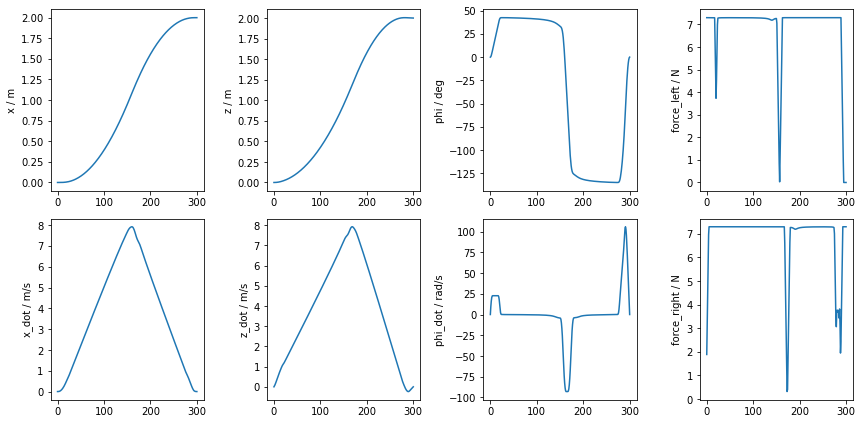

In [13]:
waypoint = np.array([2, 2])
planner_ab = TrajectoryGenerator(waypoint)
planner_ab.solve()
planner_ab.print_stats()
planner_ab.plot_results()

In [14]:
animation.render(planner_ab.states)

## Flight A-B with obstacle

Terminal time: 0.5904908054467835
Stepsize: 0.0014762270136169586
Number of iterations: 51


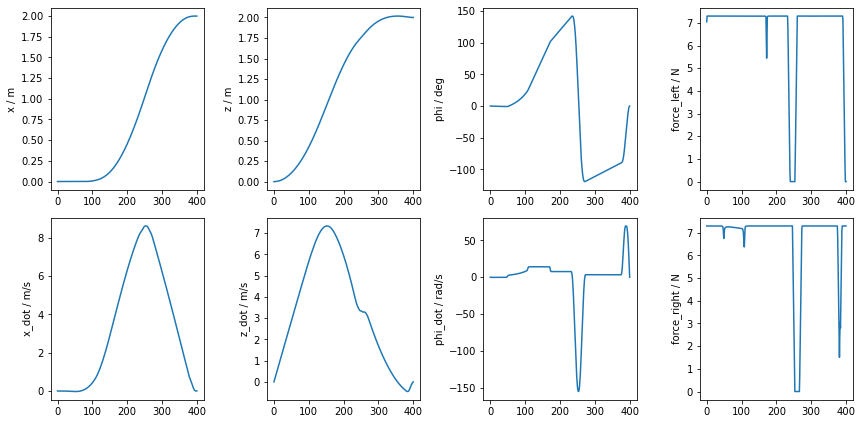

In [15]:
waypoint = np.array([2, 2])
planner_ab_obstacle = TrajectoryGenerator(waypoint, steps_to_waypoint=400, enable_obstacle=True)
planner_ab_obstacle.solve()
planner_ab_obstacle.print_stats()
planner_ab_obstacle.plot_results()

In [16]:
animation_with_obstacle.render(planner_ab_obstacle.states)

## Flight A-B-A

In [17]:
waypoint = [np.array([2, 2]), np.zeros(2)]
planner_aba = TrajectoryGenerator(waypoint)
planner_aba.solve()
planner_aba.print_stats()
planner_aba.plot_results()

Terminal time: [0.49610093 0.49610094]
Stepsize: [0.00165367 0.00165367]
Number of iterations: 48


In [18]:
animation.render(planner_aba.states)

## Flight A-B-A with obstacle

In [19]:
waypoint = [np.array([4, 4]), np.zeros(2)]
steps_to_waypoint = 500

### Without regularization

In [20]:
planner_aba_obstacle = TrajectoryGenerator(waypoint, steps_to_waypoint, enable_obstacle=True)
planner_aba_obstacle.solve()
planner_aba_obstacle.print_stats()
planner_aba_obstacle.plot_results()

Terminal time: [0.74812567 0.74812532]
Stepsize: [0.00149625 0.00149625]
Number of iterations: 62


In [21]:
animation_with_obstacle.render(planner_aba_obstacle.states)

### With regularization

In [22]:
planner_aba_obstacle_regularized = TrajectoryGenerator(waypoint, steps_to_waypoint, enable_regularization=True, enable_obstacle=True)
planner_aba_obstacle_regularized.solve()
planner_aba_obstacle_regularized.print_stats()
planner_aba_obstacle_regularized.plot_results()

Terminal time: [0.7502733 0.7502733]
Stepsize: [0.00150055 0.00150055]
Number of iterations: 46


In [23]:
animation_with_obstacle.render(planner_aba_obstacle_regularized.states)

### Comparison

In [24]:
planner_aba_obstacle.plot_results(
    planner_aba_obstacle_regularized.states,
    planner_aba_obstacle_regularized.actions
)